In [ ]:
import numpy as np
from scipy.optimize import minimize

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the IRIS dataset
iris = load_iris()
X = iris.data
y = iris.target

y = LabelEncoder().fit_transform(y)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=14)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin

class GenSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, p=2.0, kappa=0.5, lambd=0.1, epsilon=1e-6, max_iter=100):
        self.C = C
        self.p = p
        self.kappa = kappa
        self.lambd = lambd
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.W = None
        self.t = None

    def fit(self, X, y, rho):
        n_samples, n_features = X.shape
        classes = np.unique(y)
        n_classes = len(classes)
        self.classes_ = classes

        # Initialize weights and bias
        self.W = np.random.randn(n_features, n_classes - 1) * 0.01
        self.t = np.random.randn(n_classes - 1) * 0.01

        # Define the simplex encoding
        U = self._simplex_coordinates(n_classes)

        def loss(params):
            W = params[:n_features * (n_classes - 1)].reshape(n_features, n_classes - 1)
            t = params[n_features * (n_classes - 1):]
            loss = 0.0
            for i in range(n_samples):
                xi = X[i]
                yi = y[i]
                si = np.dot(xi, W) + t
                q = np.array([si @ (U[yi] - U[j]) for j in range(n_classes) if j != yi])
                hinge_loss = np.sum(np.maximum(0, 1 - q)**self.p)
                loss += rho[i] * hinge_loss
            loss /= n_samples
            loss += self.lambd * np.sum(W**2)
            return loss

        initial_params = np.hstack([self.W.ravel(), self.t])
        result = minimize(loss, initial_params, method='L-BFGS-B', tol=self.epsilon, options={'maxiter': self.max_iter})
        self.W = result.x[:n_features * (n_classes - 1)].reshape(n_features, n_classes - 1)
        self.t = result.x[n_features * (n_classes - 1):]

    def predict(self, X):
        U = self._simplex_coordinates(len(self.classes_))
        scores = np.dot(X, self.W) + self.t
        predictions = np.argmin([np.linalg.norm(scores - u, axis=1) for u in U], axis=0)
        return self.classes_[predictions]

    def _simplex_coordinates(self, K):
        U = np.zeros((K, K - 1))
        for k in range(K):
            if k > 0:
                U[k, :k] = -1 / np.sqrt(k * (k + 1))
            if k < K - 1:
                U[k, k] = k / np.sqrt((k + 1) * (k + 2)) # Avoid division by zero and invalid values
        return U

In [11]:
from sklearn.metrics import accuracy_score

# Define parameters
rho = np.ones(X_train.shape[0])
p = 2
kappa = 0.5
lambd = 0.1
epsilon = 1e-6

# Train GenSVM
gensvm = GenSVM(C=1.0, p=p, kappa=kappa, lambd=lambd, epsilon=epsilon, max_iter=100)
gensvm.fit(X_train, y_train, rho)

# Predict and evaluate
y_pred = gensvm.predict(X_test)

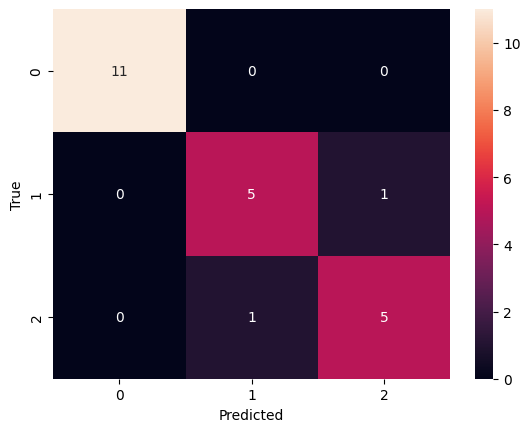

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.83      0.83      0.83         6
           2       0.83      0.83      0.83         6

    accuracy                           0.91        23
   macro avg       0.89      0.89      0.89        23
weighted avg       0.91      0.91      0.91        23

Test Accuracy: 0.9130434782608695
Test Recall: 0.9130434782608695
Test F1-score: 0.9130434782608695
Test Precision: 0.9130434782608695


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
# Print classification report
print(classification_report(y_test, y_pred))

# Additional metrics
# auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')

print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

## midifying

In [1]:
import numpy as np
from scipy.optimize import minimize

In [8]:
from sklearn.metrics import accuracy_score

# Define parameters
rho = np.ones(X_train.shape[0])
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer
accuracy_scorer = make_scorer(accuracy_score)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'p': [1.0, 2.0],
    'kappa': [0.1, 0.5, 1.0],
    'lambd': [0.01, 0.1, 1.0],
    'epsilon': [1e-6, 1e-4, 1e-2]
}

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(GenSVM(), param_grid, scoring=accuracy_scorer, cv=5 , verbose=2)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train, rho=rho)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation accuracy: {:.2f}".format(best_score))

# Predict and evaluate on the test set using the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END .C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.01, p=1.0; total time=   3.5s
[CV] END .C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.01, p=1.0; total time=   3.7s
[CV] END .C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.01, p=1.0; total time=   3.2s
[CV] END .C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.01, p=1.0; total time=   1.9s
[CV] END .C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.01, p=1.0; total time=   1.7s
[CV] END .C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.01, p=2.0; total time=   0.7s
[CV] END .C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.01, p=2.0; total time=   0.7s
[CV] END .C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.01, p=2.0; total time=   0.6s
[CV] END .C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.01, p=2.0; total time=   0.8s
[CV] END .C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.01, p=2.0; total time=   0.6s
[CV] END ..C=0.1, epsilon=1e-06, kappa=0.1, lambd=0.1, p=1.0; total time=   0.7s
[CV] END ..C=0.1, epsilon=1e-06, kappa=0.1, la

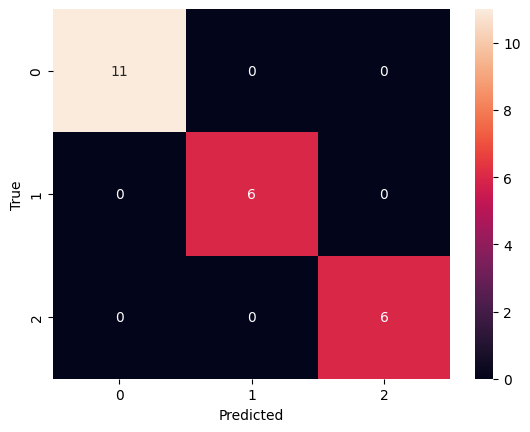

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

Test Accuracy: 1.0
Test Recall: 1.0
Test F1-score: 1.0
Test Precision: 1.0


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
# Print classification report
print(classification_report(y_test, y_pred))

# Additional metrics
# auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')

print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

# simpler: SVC!

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Define and train the GenSVM model
class GenSVM:
    def __init__(self, C=1.0, kernel='linear', p=1.0, kappa=-0.95):
        self.C = C
        self.kernel = kernel
        self.p = p
        self.kappa = kappa
        self.model = SVC(C=self.C, kernel=self.kernel, decision_function_shape='ovr')

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

# Train the GenSVM model
gensvm = GenSVM(C=1.0, kernel='linear', p=2.0, kappa=0.5)
gensvm.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = gensvm.predict(X_test)

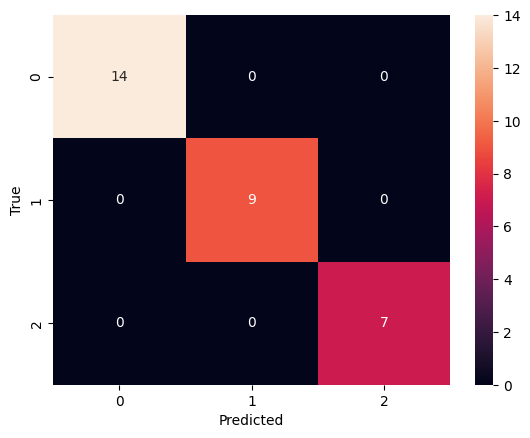

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         7

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Test Accuracy: 1.0
Test Recall: 1.0
Test F1-score: 1.0
Test Precision: 1.0


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
# Print classification report
print(classification_report(y_test, y_pred))

# Additional metrics
# auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')

print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)